In [2]:
# import libraries, packages
import numpy as np
import matplotlib.pyplot as plt

### Code provided by Tolbert in his original email. 

In [3]:
# Set parameters
n=100
p=.5

# Initial Parameters of the Model
x=np.random.binomial(1, p, 100)
c_list=[]
payout_list=[]
x_c=.75
x_d=-.5
alpha=.15

# Calculating the increase of c for each round
for stage in range(1,10):
    c=sum(x)/len(x)
    d=1-c
    payout=(c*x_c)+(d*x_d)
    if payout > 0:
        increase_c=alpha*d*n
        improvement=0
        i=0
        while improvement < increase_c:
            if x[i]==0:
                x[i]=1
                improvement= improvement+1
            i=i+1
    c_list.append(c)
    payout_list.append(payout)
    

### Rewriting the model.

Clarifying from the previous model: 
* omitted binomial sampling of creditworthiness
* omitted improvement, increase_c variables
* converted to a function for multiple test runs

First, we show the simple model where the lender lends if the payoff is greater than 0.

In [4]:
def lending_model(n_cycle, c, x_c, x_d, alpha):

    # initialization
    d = 1-c
    cs = []
    payoffs = []

    for i in range(n_cycle):
        # calculate payoff
        payoff = c*x_c + d*x_d

        # append cs values
        cs.append(c)

        # if the payoff is positive, make the trade
        if payoff > 0: 
            # make the trade
            payoffs.append(payoff)

            # increase c & recalc d
            c = c + alpha*(1-c)
            d = 1-c
        else:
            payoffs.append(0)
        
    return cs, payoffs

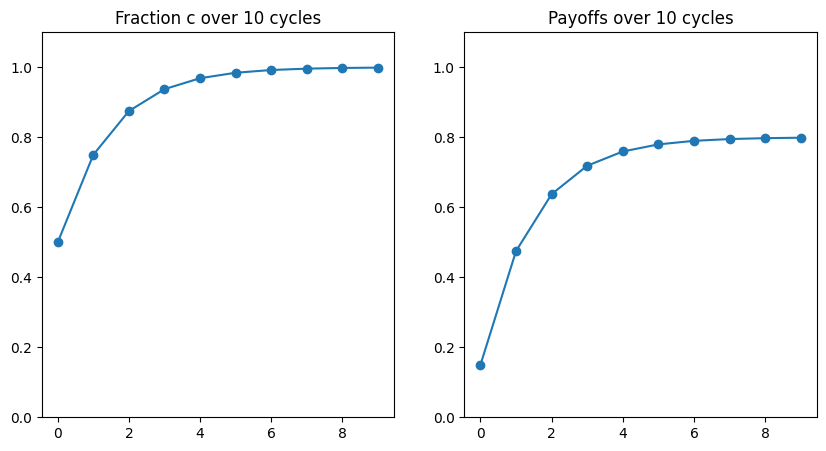

In [5]:
# Initial Parameters of the Model
n_cycle = 10
c = 0.5

x_c = 0.8
x_d = -.5
alpha = .5

# Run the model for the following initial parameters. 
cs, payoffs = lending_model(n_cycle, c, x_c, x_d, alpha)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

t = range(0,len(cs))
ax[0].plot(t, cs, '-o')
ax[0].set_title(f'Fraction c over {len(cs)} cycles')
ax[0].set_ylim([0, 1.1])

ax[1].plot(t, payoffs, '-o')
ax[1].set_title(f'Payoffs over {len(cs)} cycles')
ax[1].set_ylim([0, 1.1])

plt.show()

Now, we want to modify the function so that exponential discounting is considered. (Abusing terminology, this is not really expected value, it's time-discounted value). 

$$
\text{expvalue} = cx_c + dx_d + \sum^{\infty}_{i=1}\beta^i \left[ (c-\alpha^ic+\alpha^i)x_c + (1-c+\alpha^ic-\alpha^i)x_d \right]\\
= cx_c + dx_d + \left(\frac{cx_c}{1-\beta}-\frac{cx_c}{1-\alpha\beta}+\frac{x_c}{1-\alpha\beta}\right) + \left(\frac{x_d}{1-\beta}-\frac{cx_d}{1-\beta}+\frac{cx_d}{1-\alpha\beta}-\frac{x_d}{1-\alpha\beta}\right)\\
= cx_c + dx_d + \frac{c(x_c-x_d)+x_d}{1-\beta} + \frac{(x_c-x_d)(1-c)}{1-\alpha\beta}\\
$$

Simplify & check my math above! 

I'm missing a $-x_c$ that would make the equation equal only $cx_c + dx_d$ when $\beta=0$. Where did it go?

In [6]:
def lending_model_discounting(n_cycle, c, x_c, x_d, alpha, beta):

    # initialization
    d = 1-c
    cs = []
    payoffs = []

    for i in range(n_cycle):
        # calculate payoff
        payoff = c*x_c + d*x_d

        # append cs values
        cs.append(c)

        # expected value of trade
        exp_value = payoff + (c*(x_c-x_d)+x_d)/(1-beta) + ((x_c-x_d)*(1-c))/(1-alpha*beta) - x_c

        # if expected value is positive, make the trade
        if exp_value > 0: 
            # make the trade
            payoffs.append(payoff)

            # increase c & recalc d
            c = c + alpha*(1-c)
            d = 1-c
        else:
            payoffs.append(0)
        
    return cs, payoffs

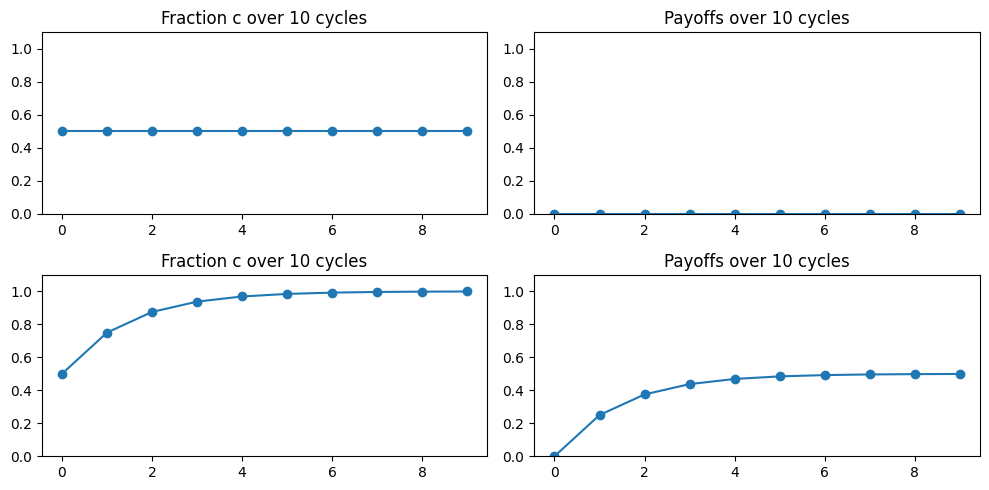

In [7]:
# Initial Parameters of the Model
n_cycle = 10
c = .5

x_c = .5
x_d = -.5
alpha = .5
beta = 0.1

# Run the model for the following initial parameters. 
cs, payoffs = lending_model(n_cycle, c, x_c, x_d, alpha)
cs_d, payoffs_d = lending_model_discounting(n_cycle, c, x_c, x_d, alpha, beta)

# Plot
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
axes = ax.flatten()

# Plot Non-Time-Discounted
t = range(0,len(cs))
axes[0].plot(t, cs, '-o')
axes[0].set_title(f'Fraction c over {len(cs)} cycles')
axes[0].set_ylim([0, 1.1])

axes[1].plot(t, payoffs, '-o')
axes[1].set_title(f'Payoffs over {len(cs)} cycles')
axes[1].set_ylim([0, 1.1])

# Plot Time-Discounted
t = range(0,len(cs_d))
axes[2].plot(t, cs_d, '-o')
axes[2].set_title(f'Fraction c over {len(cs)} cycles')
axes[2].set_ylim([0, 1.1])

axes[3].plot(t, payoffs_d, '-o')
axes[3].set_title(f'Payoffs over {len(cs)} cycles')
axes[3].set_ylim([0, 1.1])

fig.tight_layout()
plt.show()

Now instead of looking at the payoff to determine if lenders should loan to a community, we look at the utility that lenders would  obtain from loaning

if utility > 0, then lend, otherwise do not lend. 

Utility function considering an infinite time-horizon and a discount factor $\beta. 

$$
  U(c, x_c, d, x_d) = \sum_{t=0}^{\infty} \beta^t[c_t x_c+d_t x_d]\\
    = \sum_{t=0}^\infty \beta^t\left[\left[ -(1-\alpha)^t(1-c)+1\right] x_c+\left[(1-\alpha)^t(1-c)\right] x_d\right]\\
    = \sum_{t=0}^\infty \beta^t\left[x_c+(x_d-x_c)(1-\alpha)^t(1-c)\right]
$$



In [8]:
def utility(t, x_c, x_d, c, alpha, beta) :
    u = beta**t * (x_c + (x_d - x_c)*((1-alpha)**t)*(1 - c))
    return u

In [9]:
def lending_model_utilty(t, c, x_c, x_d, alpha, beta):
    
    d = 1-c
    cs = []
    payoffs = []
    utilities = []

    u = x_c + (x_d-x_c)*d
    utilities.append(u)
    

    for i in range(t):
        payoff = x_c*c + x_d*d
        
        u = utility(t, x_c, x_d, c, alpha, beta)
        
        cs.append(c)
        if u > 0:
            utilities.append(u)
            payoffs.append(payoff)
            c = c + alpha*(1-c)
            d = 1-c
        # else:
        #     utilities.append(0)
        #     payoffs.append(0)
    return cs, payoffs, utilities


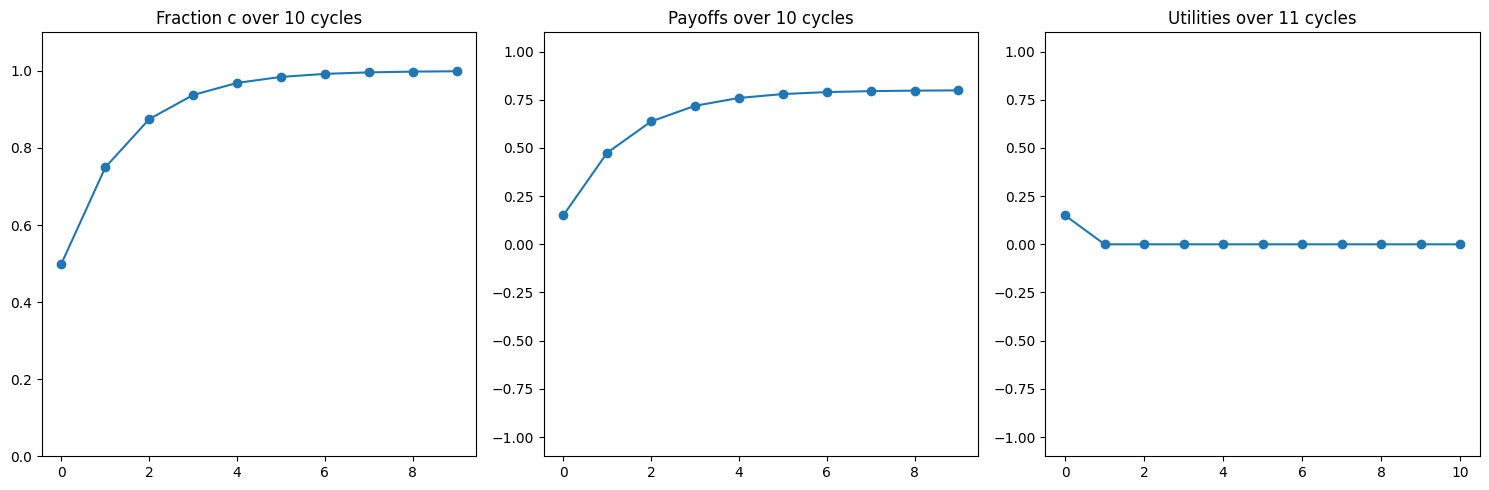

In [10]:
t = 10
c = .5

x_c = .8
x_d = -.5
alpha = .5
beta = 0.1

# Run the model for the following initial parameters. 
cs, payoffs = lending_model(t, c, x_c, x_d, alpha)
cs_d, payoffs_d = lending_model_discounting(t, c, x_c, x_d, alpha, beta)
cs_u, payoffs_u, u = lending_model_utilty(t, c, x_c, x_d, alpha, beta)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
axes = ax.flatten()

# # Plot Non-Time-Discounted
# ts = range(0,len(cs))
# axes[0].plot(ts, cs, '-o')
# axes[0].set_title(f'Fraction c over {len(cs)} cycles')
# axes[0].set_ylim([0, 1.1])

# axes[1].plot(ts, payoffs, '-o')
# axes[1].set_title(f'Payoffs over {len(cs)} cycles')
# axes[1].set_ylim([0, 1.1])

# # Plot Time-Discounted
# ts = range(0,len(cs_d))
# axes[2].plot(ts, cs_d, '-o')
# axes[2].set_title(f'Fraction c over {len(cs)} cycles')
# axes[2].set_ylim([0, 1.1])

# axes[3].plot(ts, payoffs_d, '-o')
# axes[3].set_title(f'Payoffs over {len(cs)} cycles')
# axes[3].set_ylim([0, 1.1])

# Plot Utility
ts = range(0,len(cs_u))
axes[0].plot(ts, cs_u, '-o')
axes[0].set_title(f'Fraction c over {len(cs)} cycles')
axes[0].set_ylim([0, 1.1])

axes[1].plot(ts, payoffs, '-o')
axes[1].set_title(f'Payoffs over {len(cs)} cycles')
axes[1].set_ylim([-1.1, 1.1])

ts = range(0, len(u))
           
axes[2].plot(ts, u, '-o')
axes[2].set_title(f'Utilities over {len(u)} cycles')
axes[2].set_ylim([-1.1, 1.1])

fig.tight_layout()
plt.show()